#Import libraries


In [6]:
import pandas as pd
import numpy as np

import re

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import ToktokTokenizer
import nltk
nltk.download('stopwords')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Load data




In [3]:
df = pd.read_csv("/content/drive/MyDrive/TFM/abstracts.csv", sep=";")
#Drop repo, keep only abstracts and label
abstracts = df.drop('Repo', axis=1)
print(abstracts.shape)
abstracts.head()

(25828, 2)


,Text,Label
0,"""https://paperswithcode.com/method/multiple-ra...",General
1,"""https://paperswithcode.com/method/dblock DBlo...",General
2,"""https://paperswithcode.com/method/gan-tts GAN...",Sequential
3,"""https://paperswithcode.com/method/conditional...",General
4,"""https://paperswithcode.com/method/gblock GBlo...",General


We create another data frame where we remove the General category and all duplicates 

In [4]:
no_dups = abstracts[abstracts['Label'] != 'General']
print('There were',sum(no_dups.duplicated()), 'duplicates')
no_dups = no_dups.drop_duplicates()
no_dups = no_dups.reset_index(drop=True)

print('Final dataset size without duplicates and General :', no_dups.shape)

There were 16956 duplicates
Final dataset size without duplicates and General : (976, 2)


Let's analyze the distribution of the categories on both datasets

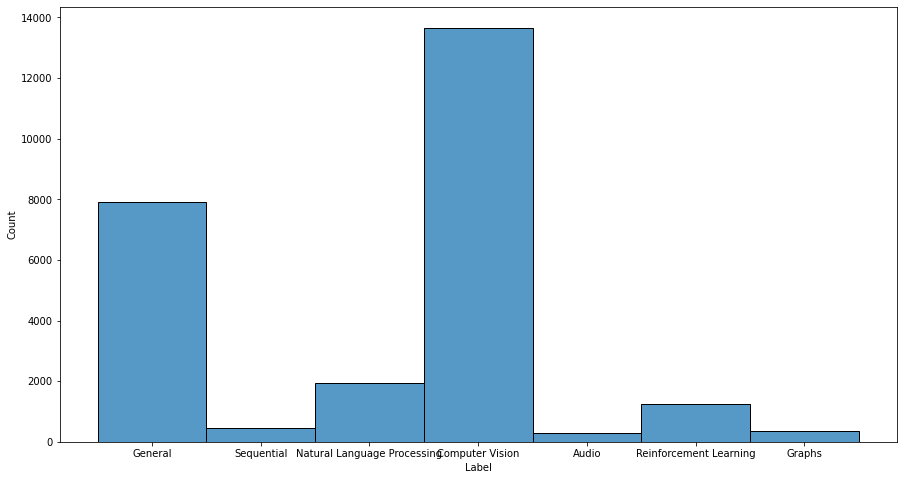

In [7]:
plt.figure(figsize=(15,8))
sns.histplot(x='Label',data=abstracts)

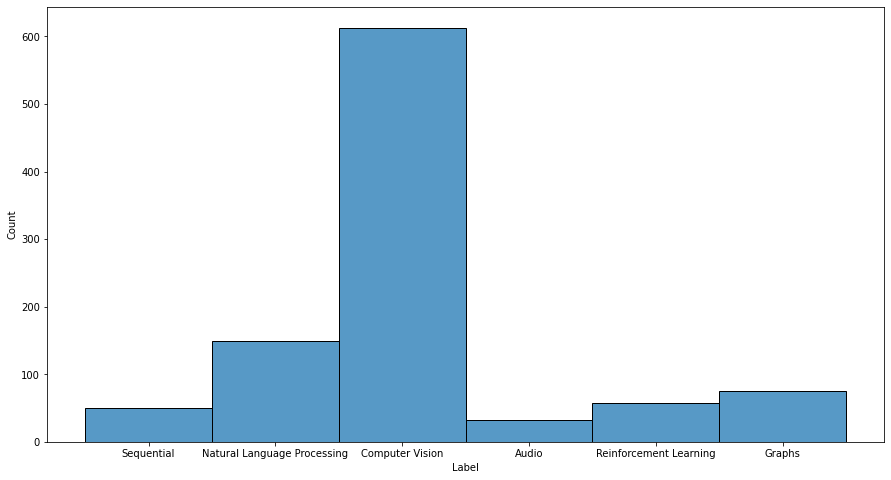

In [8]:
plt.figure(figsize=(15,8))
sns.histplot(x='Label',data=no_dups)

In [9]:
def cleaner(text):
    """
    Preprocess the abstracts
    """
    #Remove textbf mathbf mathcal etc?
    #Title repeated 3 times at beginning?
    #Remove links
    text = re.sub(r'https:\S+',' ',str(text))
    #Remove equations
    text = re.sub(r'(\$[^$]+\$)|(\$\$[^$]+\$\$)',' ',text)
    #Remove common abbreviations
    text = re.sub(r'i\.e\.|e\.g\.|etc.',' ',text)
    #Remove special characters
    text = re.sub(r'\W',' ',text)
    #Remove words with only one character
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    #Remove nones
    text = re.sub(r'[Nn]one',' ', text)
    #Substitute long space for one space
    text = re.sub(r'\s+',' ', text, flags=re.I)
    #Remove new line characters
    text = text.rstrip()
    #Change text to lower case
    text = text.lower()
    return text

Before applying any topic modelling algorithms we will clean our data form noise and special characters that won't provide us of any information. In this process we focus on the following:

*   Remove links
*   Remove equations
*   Remove abbreviations
*   Remove special characrer, such as *, /, !,etc.
*   Remove words with only one character
*   Substitute long for single spaces
*   Remove new line characters
*   Tranforming text to lower case



In [10]:
#Preprocess
abstracts['Tokens'] = abstracts.Text.apply(cleaner)
print(abstracts['Tokens'].head())
#Tokenize
tokenizer = ToktokTokenizer() 
abstracts["Tokens"] = abstracts.Tokens.apply(tokenizer.tokenize)

0     multiple random window discriminator multiple...
1     dblock dblock dblock is residual based block ...
2     gan tts gan tts gan tts is generative adversa...
3     conditional dblock conditional dblock conditi...
4     gblock gblock gblock is type of residual bloc...
Name: Tokens, dtype: object


In [11]:
#Preprocess
no_dups['Tokens'] = no_dups.Text.apply(cleaner)
#Tokenize
tokenizer = ToktokTokenizer() 
no_dups["Tokens"] = no_dups.Tokens.apply(tokenizer.tokenize)

Once the frist preprocess has been done, we move on to removing stopwords and stemming.

In [12]:
#Second filter stopwords, digits, urls
STOPWORDS = set(stopwords.words("english"))

def filtrar_stopword_digitos(tokens):
    """
    Filtra stopwords y digitos de una lista de tokens.
    """
    return [token for token in tokens if token not in STOPWORDS 
            and not token.isdigit()]

abstracts["Tokens"] = abstracts.Tokens.apply(filtrar_stopword_digitos)
no_dups["Tokens"] = no_dups.Tokens.apply(filtrar_stopword_digitos)

In [13]:
stemmer = SnowballStemmer("english")

def stem_words(tokens):
    """
    Reduce cada palabra de una lista dada a su raíz.
    """
    return [stemmer.stem(token) for token in tokens]

abstracts["Tokens"] = abstracts.Tokens.apply(stem_words)
no_dups["Tokens"] = no_dups.Tokens.apply(stem_words)

In [14]:
abstracts.head()

,Text,Label,Tokens
0,"""https://paperswithcode.com/method/multiple-ra...",General,"[multipl, random, window, discrimin, multipl, ..."
1,"""https://paperswithcode.com/method/dblock DBlo...",General,"[dblock, dblock, dblock, residu, base, block, ..."
2,"""https://paperswithcode.com/method/gan-tts GAN...",Sequential,"[gan, tts, gan, tts, gan, tts, generat, advers..."
3,"""https://paperswithcode.com/method/conditional...",General,"[condit, dblock, condit, dblock, condit, dbloc..."
4,"""https://paperswithcode.com/method/gblock GBlo...",General,"[gblock, gblock, gblock, type, residu, block, ..."


In [15]:
no_dups.head()

,Text,Label,Tokens
0,"""https://paperswithcode.com/method/gan-tts GAN...",Sequential,"[gan, tts, gan, tts, gan, tts, generat, advers..."
1,"""https://paperswithcode.com/method/bert BERT B...",Natural Language Processing,"[bert, bert, bert, bidirect, encod, represent,..."
2,"""https://paperswithcode.com/method/fasttext fa...",Natural Language Processing,"[fasttext, fasttext, fasttext, embed, exploit,..."
3,"""https://paperswithcode.com/method/faster-r-cn...",Computer Vision,"[faster, cnn, faster, cnn, faster, cnn, object..."
4,"""https://paperswithcode.com/method/rpn RPN Reg...",Computer Vision,"[rpn, region, propos, network, region, propos,..."


In [16]:
with open("/content/drive/MyDrive/TFM/preprocessed_lda.csv", 'w', encoding = 'utf-8-sig') as f:
  abstracts.to_csv(f)

In [17]:
with open("/content/drive/MyDrive/TFM/preprocessed_lda_wodups.csv", 'w', encoding = 'utf-8-sig') as f:
  no_dups.to_csv(f)